# Analyzing NYC Taxi Fares with RAPIDS

[RAPIDS](https://rapids.ai/) is a suite of GPU accelerated data science libraries with APIs that should be familiar to users of Pandas, scikit-learn, and Dask.

This notebook builds a simple data pipeline:

- we'll use cuDF to load, clean and prep some data, as well as for some feature engineering
- we'll use cuML to explore patterns the data using unsupervised learning, and build a simple predictive model on top of it

We'll learn that cuDF and cuML are GPU-accelerated libraries that are very similar to Pandas and scikit-learn (their respective CPU counterparts). The benefit of using RAPIDS libraries like cuDF and cuML is that they are much faster!

In [1]:
import glob
import os

import cudf
import cuml
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import sklearn
from tqdm.auto import tqdm

/home/ashwin/miniconda3/envs/rapids-gtc2023/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The very first operation performed using cuDF initializes the library, which has some overhead. To ensure that this initialization time is not included when we measure code execution time, we "warm up" cuDF before using it for any real work:

In [2]:
_ = cudf.Series([1])  # warmup

## Get the data

The main dataset we'll be using in this notebook comes from the [New York City Taxi and Limousine Commision (TLC)](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The TLC publishes data about taxi rides, including pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data is made available as PARQUET files, and is published monthly.

The code below downloads the PARQUET files containing trip data for "Yellow" Taxis from the year 2021. It also downloads a second, smaller dataset: a CSV file containing geographical information that will be useful in later parts of our analysis.

In [3]:
def download(url, fname):
    """
    Download file from `url`, writing the result to `fname`.
    If `fname` already exists, do nothing.
    """
    # this code adapted from the tqdm examples
    # https://github.com/tqdm/tqdm/blob/master/examples/tqdm_requests.py
    if os.path.exists(fname):
        return
    response = requests.get(url, stream=True)
    with tqdm.wrapattr(
        open(fname, "wb"),
        "write",
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
        miniters=1,
        desc=fname,
        total=int(response.headers.get("content-length", 0)),
    ) as fout:
        for chunk in response.iter_content(chunk_size=4096):
            fout.write(chunk)


def download_taxi_data(n):
    """
    Download `n` months of taxi data.
    """
    base = "https://d37ci6vzurychx.cloudfront.net/trip-data/"
    fname = "yellow_tripdata_2021-{i:02d}.parquet"
    url = base + fname
    for i in range(1, n + 1):
        download(url.format(i=i), fname.format(i=i))


def download_taxi_zones():
    download(
        "https://gist.githubusercontent.com/shwina/72d79165ce9605d8f6e3378ae717b16b/raw/84a47bc587c99c6736f38a97f9dcc32ba8f89b05/taxi_zones.csv",
        "taxi_zones.csv",
    )


# adjust n between 1-12 depending on the size of analysis
download_taxi_data(n=6)
download_taxi_zones()

# Part 1: Loading and Preparing Data

Our dataset is a collection of Parquet files containing NYC taxi trip data. Another smaller dataset `taxi_zones.csv` contains some geographical information that we'll use later:

In [4]:
!ls

cufile.log		      yellow_tripdata_2021-01.parquet
NYCTaxi-Blank.ipynb	      yellow_tripdata_2021-02.parquet
NYCTaxi.ipynb		      yellow_tripdata_2021-03.parquet
NYCTaxi-JohnZ_224.ipynb       yellow_tripdata_2021-04.parquet
NYCTaxi-Tutorial-Blank.ipynb  yellow_tripdata_2021-05.parquet
taxi_zones.csv		      yellow_tripdata_2021-06.parquet


### 1.1 Reading the data

First, we'll read the Parquet data into a Pandas dataframe using the `pandas.read_parquet()` function. Then, we'll see how to do the same thing with cuDF.

In [5]:
# TODO: Use Pandas to read all the parquet files into a variable
# named `df`. Use cUDF to do the same thing, and save the result to a
# variable named `gdf`

df = pd.read_parquet(sorted(list(glob.glob("*.parquet"))))
gdf = cudf.read_parquet(sorted(list(glob.glob("*.parquet"))))

In [6]:
print(type(df))
print(type(gdf))

<class 'pandas.core.frame.DataFrame'>
<class 'cudf.core.dataframe.DataFrame'>


In [7]:
display(df)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12179185,2,2021-06-30 23:25:00,2021-06-30 23:39:00,NaN,3.27,NaN,None,162,249,0,14.28,0.0,0.5,2.81,0.0,0.3,20.39,NaN,NaN
12179186,2,2021-06-30 23:36:02,2021-07-01 00:05:56,NaN,9.93,NaN,None,217,239,0,32.03,0.0,0.5,7.69,0.0,0.3,43.02,NaN,NaN
12179187,6,2021-06-30 23:06:09,2021-06-30 23:06:45,NaN,7.31,NaN,None,265,76,0,39.50,0.0,0.5,0.00,0.0,0.3,40.30,NaN,NaN
12179188,2,2021-06-30 23:01:24,2021-06-30 23:10:20,NaN,2.83,NaN,None,143,236,0,13.51,0.0,0.5,3.57,0.0,0.3,20.38,NaN,NaN


In [8]:
display(gdf)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.0,0.5,0.00,0.0,0.3,11.80,2.5,<NA>
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.5,0.5,0.00,0.0,0.3,4.30,0.0,<NA>
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.5,0.5,8.65,0.0,0.3,51.95,0.0,<NA>
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.5,0.5,6.05,0.0,0.3,36.35,0.0,<NA>
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.5,0.5,4.06,0.0,0.3,24.36,2.5,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12179185,2,2021-06-30 23:25:00,2021-06-30 23:39:00,<NA>,3.27,<NA>,<NA>,162,249,0,14.28,0.0,0.5,2.81,0.0,0.3,20.39,<NA>,<NA>
12179186,2,2021-06-30 23:36:02,2021-07-01 00:05:56,<NA>,9.93,<NA>,<NA>,217,239,0,32.03,0.0,0.5,7.69,0.0,0.3,43.02,<NA>,<NA>
12179187,6,2021-06-30 23:06:09,2021-06-30 23:06:45,<NA>,7.31,<NA>,<NA>,265,76,0,39.50,0.0,0.5,0.00,0.0,0.3,40.30,<NA>,<NA>
12179188,2,2021-06-30 23:01:24,2021-06-30 23:10:20,<NA>,2.83,<NA>,<NA>,143,236,0,13.51,0.0,0.5,3.57,0.0,0.3,20.38,<NA>,<NA>


A few things to note:

- cuDF offers a Pandas-like API. It doesn't require you to learn a new library to take advantage of the GPU.
- cuDF has a `cudf.DataFrame` type that is analogous to `pd.DataFrame`. The primary difference between the two is that `cudf.DataFrame` lives on the GPU and any operations on it utilize the GPU rather than the CPU (and are hence much faster)

### 1.2 Data Cleanup

Next, we're going to do some preliminary cleanup of our data.

We've defined a helper function called `clean_columns` below. This helper function accepts a Pandas DataFrame as its first parameter, and does four things:

1. Converts the column names to all lowercase, and removes any extraneous spaces in the column names.
2. Discards columns that we won't use in our analysis.
3. Casts columns to the appropriate data type.
3. Replace missing values ("nulls") in columns with a sentinel value -1.

In particular, note the operations invoked on the input DataFrame `df`:

- `df.columns`
- `df.rename`
- `df.drop`
- `df[]` (indexing operation returning a `Series`)
- `Series.fillna()`
- `Series.asype()`

In [9]:
def clean_columns(df, columns_to_keep, column_renames):
    """
    Perform column cleanup on the input DataFrame `df`.
    Drop any columns not present in `columns_to_keep`.
    Then, rename columns according to the mapping `column_renames`.
    Finally, cast any numeric columns from 64-bit to 32-bit data types,
    while filling any nulls that may be present with the sentinel
    value -1.
    
    Parameters
    ----------
    df: DataFrame
        Input dataframe
    columns_to_keep: list
        List of columns to keep in the result
    column_renames: dict
        Mapping that specifies the column renaming to apply

    Returns
    -------
    DataFrame
    """
    # rename columns
    colname_cleanup = {col: col.strip().lower() for col in df.columns}
    df = df.rename(columns=colname_cleanup)
    df = df.rename(column_renames, axis=1)

    # Simplify the payment_type column
    df["is_credit_card"] = df["payment_type"] == 1

    # Drop unwanted columns, and cast data down from
    # 64-bit type to 32-bit type when possible
    for col in df.columns:
        if col not in columns_to_keep:
            print(f"Dropping ({col})")
            df = df.drop(columns=col)
            continue

        # cast int64->int32, float64->float32
        # and fill nulls with -1
        dtype = df[col].dtype
        if dtype.kind in {"i", "f"}:
            if dtype.itemsize == 8:
                df[col] = df[col].astype(dtype.kind + str(dtype.itemsize))
            df[col] = df[col].fillna(-1)

    return df

Now, let's call the `clean_columns` on our Pandas dataframe `df`:

In [10]:
%%time

columns_to_keep = [
    "pickup_datetime",
    "dropoff_datetime",
    "passenger_count",
    "pickup_longitude",
    "pickup_latitude",
    "rate_code",
    "fare_amount",
    "pickup_location",
    "dropoff_location",
    "is_credit_card",
    "airport_fee",
]

column_renames = {
    "tpep_pickup_datetime": "pickup_datetime",
    "tpep_dropoff_datetime": "dropoff_datetime",
    "ratecodeid": "rate_code",
    "pulocationid": "pickup_location",
    "dolocationid": "dropoff_location",
}

df = clean_columns(df, columns_to_keep, column_renames)
display(df.head())

Dropping (vendorid)
Dropping (trip_distance)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (extra)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (improvement_surcharge)
Dropping (total_amount)
Dropping (congestion_surcharge)


,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,1.0,138,132,29.0,-1.0,True
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True


CPU times: user 4.82 s, sys: 3.27 s, total: 8.09 s
Wall time: 7.56 s


What about `gdf`? How can we do the same cleanup on `gdf` as we did with `df`? Do we need to define a new helper function that can work with cuDF DataFrames?

In [11]:
%%time
# TODO: do the same cleanup on `gdf` as we did with `df`

gdf = clean_columns(gdf, columns_to_keep, column_renames)
display(gdf.head())

Dropping (vendorid)
Dropping (trip_distance)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (extra)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (improvement_surcharge)
Dropping (total_amount)
Dropping (congestion_surcharge)


,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,1.0,138,132,29.0,-1.0,True
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True


CPU times: user 89.4 ms, sys: 114 ms, total: 203 ms
Wall time: 248 ms


Notice that `clean_columns` can be used with a cuDF DataFrame without any changes! This is because cuDF DataFrames support many of the same operations (like `drop`, `rename`, `astype`, `fillna`) as Pandas DataFrames.

### 1.3 Visualizing and filtering the data

The next step in our analysis is to identify any statistical anomalies in the data, e.g., data that was entered incorrectly due to human error?

Data Visualization is a great tool to find these kinds of issues.

As an example, we'll use the [Seaborn](https://seaborn.pydata.org/) library to make a boxplot from our data, which will show us the outliers in the dataset. 

Seaborn does not currently support cuDF DataFrames as input, so we need to use the `.to_pandas()` method to convert to a Pandas DataFrame before passing it to Seaborn.

For a more general guide on how to use RAPIDS with most of the popular visualization libraries, see the viz gallery in our docs: https://docs.rapids.ai/visualization

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

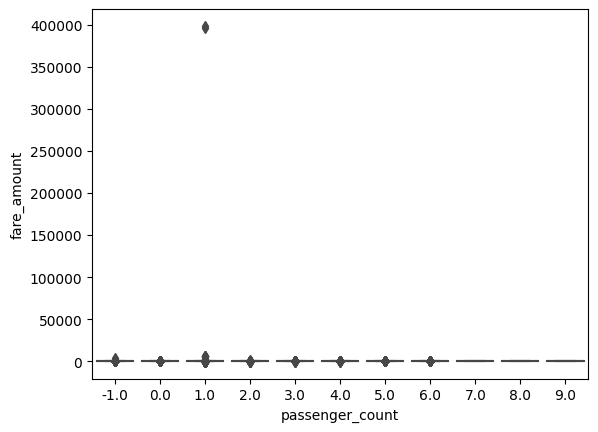

In [12]:
# TODO: using the cuDF DataFrame gdf, make a boxplot
# of the fare_amount to passenger_count using seaborn

sns.boxplot(x="passenger_count", y="fare_amount", data=gdf.to_pandas())

The dataset clearly has some significant outliers. Let's filter the data to throw out some of the outliers and also to remove missing values:

In [13]:
query_frags = [
    "fare_amount > 0",
    "fare_amount < 500",
    "passenger_count > 0",
    "passenger_count < 6",
]
query = " and ".join(query_frags)
display(query)

'fare_amount > 0 and fare_amount < 500 and passenger_count > 0 and passenger_count < 6'

In [14]:
# TODO: apply the query above to the DataFrame `gdf`
# remember to reset the index afterwards.
# (any time you filter the dataframe, it's a good idea to reset its index)


gdf = gdf.query(query)
gdf = gdf.reset_index(drop=True)

# inspect the results of cleaning
display(gdf)

,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True
3,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True
4,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.0,224,68,8.0,-1.0,True
...,...,...,...,...,...,...,...,...,...
10970246,2021-06-30 23:06:57,2021-06-30 23:17:00,1.0,1.0,230,141,9.5,0.0,True
10970247,2021-06-30 23:46:10,2021-06-30 23:56:13,1.0,1.0,230,158,9.5,0.0,True
10970248,2021-06-30 23:16:57,2021-06-30 23:24:52,1.0,1.0,90,107,7.0,0.0,True
10970249,2021-06-30 23:35:03,2021-06-30 23:40:57,1.0,1.0,249,231,6.5,0.0,True


<Axes: xlabel='passenger_count', ylabel='fare_amount'>

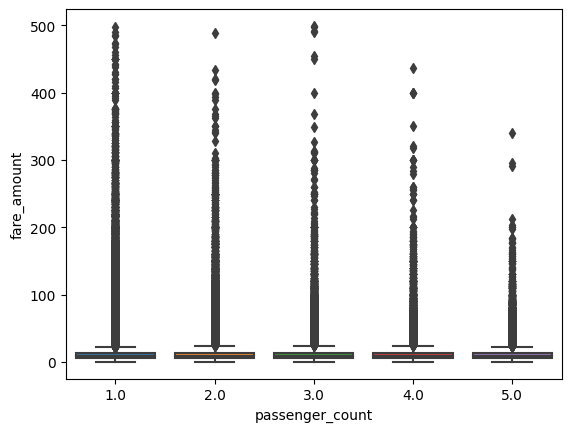

In [15]:
sns.boxplot(x="passenger_count", y="fare_amount", data=gdf.to_pandas())

Now that we've gotten rid of the more obvious outliers, we can continue with the rest of the analysis.

### 1.4 Takeaways

- cuDF offers similar classes, functions, and methods to Pandas
  - This includes functions for reading and writing data!
- cuDF DataFrames and other objects utilize GPU memory (rather than CPU memory or "RAM")
- Code that is written to use Pandas can easily be changed to use cuDF instead
- You can use cuDF with third-party libraries that work with Pandas, using the `.to_pandas()` and `.from_pandas()` functions
- By virtue of using the GPU, cuDF can be much faster than Pandas

## Part 2: Feature engineering and user-defined functions

We're going to add a few more features to our dataset, and show off some of the more complex functionality offered by cuDF.

1. Our dataset has the "location IDs" to represent the pickup and dropoff locations. We would like the actual coordinates (latitude and longitude) of the pickup and dropoff locations. Of course, that information will come from another dataset (`taxi_zones.csv`). We'll see how to use cuDF to combine the two datasets.

2. Next, we'll compute the trip distance from the pickup and dropoff coordinates using the [Haversine Distance Formula](https://en.wikipedia.org/wiki/Haversine_formula).

3. Finally, we'll extract additional useful variables from the `pickup_datetime` field using cuDF's datetime functionality.

In [16]:
gdf

,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True
3,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True
4,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.0,224,68,8.0,-1.0,True
...,...,...,...,...,...,...,...,...,...
10970246,2021-06-30 23:06:57,2021-06-30 23:17:00,1.0,1.0,230,141,9.5,0.0,True
10970247,2021-06-30 23:46:10,2021-06-30 23:56:13,1.0,1.0,230,158,9.5,0.0,True
10970248,2021-06-30 23:16:57,2021-06-30 23:24:52,1.0,1.0,90,107,7.0,0.0,True
10970249,2021-06-30 23:35:03,2021-06-30 23:40:57,1.0,1.0,249,231,6.5,0.0,True


### 2.1 Combining datasets with `merge()`

The data in `taxi_zones.csv` contains the coordinates for each location. The `'x'` and `'y'` columns refer to the longitute and latitude respectively of each location:

In [17]:
zones = cudf.read_csv("taxi_zones.csv")
zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,x,y
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.174000,40.691831
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.831299,40.616745
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.847422,40.864474
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.976968,40.723752
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.188484,40.552659
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,-73.852215,40.897932
259,260,0.133514,0.000422,Woodside,260,Queens,-73.906306,40.744235
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,-74.013023,40.709139
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,-73.946510,40.775932


Before we can combine `zones` and `gdf`, we have to do some pre-processing of both. The helper function below discards the rows in `zones` that have duplicate location information. It also discards rows in `gdf` for which the `pickup_location` and `dropoff_location` cannot be found in `zones`.

In [18]:
def drop_rows_with_repeated_or_missing_locations(zones, df):
    dup_rows = zones[(zones["LocationID"] == 103) | (zones["LocationID"] == 56)]
    zones = zones.drop(dup_rows.index, axis=0)
    zones = zones.reset_index(drop=True)

    df = df[df["pickup_location"].isin(zones["LocationID"])]
    df = df[df["dropoff_location"].isin(zones["LocationID"])]
    df = df.reset_index(drop=True)
    return zones, df

In [19]:
zones, gdf = drop_rows_with_repeated_or_missing_locations(zones, gdf)
zones = zones.set_index("LocationID")
display(zones)

,OBJECTID,Shape_Leng,Shape_Area,zone,borough,x,y
LocationID,,,,,,,
1,1,0.116357,0.000782,Newark Airport,EWR,-74.174000,40.691831
2,2,0.433470,0.004866,Jamaica Bay,Queens,-73.831299,40.616745
3,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,-73.847422,40.864474
4,4,0.043567,0.000112,Alphabet City,Manhattan,-73.976968,40.723752
5,5,0.092146,0.000498,Arden Heights,Staten Island,-74.188484,40.552659
...,...,...,...,...,...,...,...
259,259,0.126750,0.000395,Woodlawn/Wakefield,Bronx,-73.852215,40.897932
260,260,0.133514,0.000422,Woodside,Queens,-73.906306,40.744235
261,261,0.027120,0.000034,World Trade Center,Manhattan,-74.013023,40.709139


---

Now we have the coordinate data in `zones` for every pickup and dropoff location in our main dataset `gdf`. Let's use a merge ("join") to combine the two datasets:

In [20]:
%%time
# TODO: merge `gdf` with `zones`, using the `pickup_location` column
# and the index of `zones` respectively as the merge keys
# the result should contain two columns 'x' and `y`, representing
# the coordinates (longitude and lattitude respectively) of each
# pickup location

gdf.merge(zones, left_on="pickup_location", right_index=True, how="left")

CPU times: user 30.6 ms, sys: 4.73 ms, total: 35.3 ms
Wall time: 36.6 ms


,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,OBJECTID,Shape_Leng,Shape_Area,zone,borough,x,y
8832,2021-01-01 13:41:27,2021-01-01 13:50:03,2.0,1.0,79,158,7.5,-1.00,True,79,0.042625,0.000108,East Village,Manhattan,-73.985937,40.727620
8833,2021-01-01 13:55:08,2021-01-01 14:00:15,1.0,1.0,68,48,7.0,-1.00,True,68,0.049337,0.000111,East Chelsea,Manhattan,-73.999917,40.748428
8834,2021-01-01 13:23:21,2021-01-01 13:28:57,3.0,1.0,137,141,8.0,-1.00,True,137,0.046108,0.000116,Kips Bay,Manhattan,-73.976495,40.740439
8835,2021-01-01 13:30:33,2021-01-01 13:32:07,2.0,1.0,141,262,3.5,-1.00,True,141,0.041514,0.000077,Lenox Hill West,Manhattan,-73.959635,40.766948
8836,2021-01-01 13:38:23,2021-01-01 13:43:03,2.0,1.0,141,237,5.0,-1.00,True,141,0.041514,0.000077,Lenox Hill West,Manhattan,-73.959635,40.766948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10833245,2021-06-30 23:45:04,2021-06-30 23:58:14,1.0,1.0,163,113,11.5,0.00,True,163,0.034177,0.000041,Midtown North,Manhattan,-73.977569,40.764421
10833246,2021-06-30 23:38:50,2021-07-01 00:10:41,1.0,1.0,138,209,38.0,1.25,True,138,0.107467,0.000537,LaGuardia Airport,Queens,-73.873629,40.774376
10833247,2021-06-30 23:40:09,2021-07-01 00:15:54,3.0,2.0,132,236,52.0,1.25,True,132,0.245479,0.002038,JFK Airport,Queens,-73.786533,40.646985
10833240,2021-06-30 23:07:54,2021-06-30 23:11:46,1.0,1.0,193,193,5.0,0.00,False,193,0.065530,0.000146,Queensbridge/Ravenswood,Queens,-73.941997,40.760314


Let's compare how long Pandas takes to do the same merge:

In [21]:
df = gdf.to_pandas()
zones_cpu = zones.to_pandas()

In [22]:
%%time
df.merge(zones_cpu, left_on="pickup_location", right_index=True, how="left")

CPU times: user 1e+03 ms, sys: 462 ms, total: 1.46 s
Wall time: 1.44 s


,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,OBJECTID,Shape_Leng,Shape_Area,zone,borough,x,y
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False,142,0.038176,0.000076,Lincoln Square East,Manhattan,-73.981532,40.773633
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False,238,0.060109,0.000185,Upper West Side North,Manhattan,-73.973049,40.791705
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True,132,0.245479,0.002038,JFK Airport,Queens,-73.786533,40.646985
3,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True,68,0.049337,0.000111,East Chelsea,Manhattan,-73.999917,40.748428
4,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.0,224,68,8.0,-1.0,True,224,0.044020,0.000098,Stuy Town/Peter Cooper Village,Manhattan,-73.976598,40.731821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10835516,2021-06-30 23:06:57,2021-06-30 23:17:00,1.0,1.0,230,141,9.5,0.0,True,230,0.031028,0.000056,Times Sq/Theatre District,Manhattan,-73.984196,40.759818
10835517,2021-06-30 23:46:10,2021-06-30 23:56:13,1.0,1.0,230,158,9.5,0.0,True,230,0.031028,0.000056,Times Sq/Theatre District,Manhattan,-73.984196,40.759818
10835518,2021-06-30 23:16:57,2021-06-30 23:24:52,1.0,1.0,90,107,7.0,0.0,True,90,0.030759,0.000055,Flatiron,Manhattan,-73.996971,40.742279
10835519,2021-06-30 23:35:03,2021-06-30 23:40:57,1.0,1.0,249,231,6.5,0.0,True,249,0.036384,0.000072,West Village,Manhattan,-74.002875,40.734576


A couple of things to note:

1. The merge operation on the GPU is _fast_ (about 20x faster than CPU).

2. Unlike Pandas, `merge()` in cuDF returns rows in a non-deterministic order. In particular, the original ordering of the join keys is not preserved. We can recover the original ordering by sorting the resulting DataFrame by its index.

Below, we define a helper function that adds both pickup and dropoff coordinates `gdf`, as well as the borough name corresponding to the pickup and dropoff locations (a total of 6 new columns):

In [23]:
def add_pickup_and_dropoff_info(df, zones):
    pickup_info = (
        df[["pickup_location"]]
        .merge(
            zones[["x", "y", "borough"]],
            left_on="pickup_location",
            right_index=True,
            how="left",
        )
        .sort_index()
    )
    dropoff_info = (
        df[["dropoff_location"]]
        .merge(
            zones[["x", "y", "borough"]],
            left_on="dropoff_location",
            right_index=True,
            how="left",
        )
        .sort_index()
    )
    df["pickup_latitude"] = pickup_info["y"]
    df["pickup_longitude"] = pickup_info["x"]
    df["pickup_borough"] = pickup_info["borough"]
    df["dropoff_latitude"] = dropoff_info["y"]
    df["dropoff_longitude"] = dropoff_info["x"]
    df["dropoff_borough"] = dropoff_info["borough"]
    return df

In [24]:
gdf = add_pickup_and_dropoff_info(gdf, zones)
display(gdf)

,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,pickup_latitude,pickup_longitude,pickup_borough,dropoff_latitude,dropoff_longitude,dropoff_borough
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False,40.773633,-73.981532,Manhattan,40.782478,-73.965554,Manhattan
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False,40.791705,-73.973049,Manhattan,40.797962,-73.968168,Manhattan
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True,40.646985,-73.786533,Queens,40.620924,-73.956825,Brooklyn
3,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True,40.748428,-73.999917,Manhattan,40.695798,-73.995250,Brooklyn
4,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.0,224,68,8.0,-1.0,True,40.731821,-73.976598,Manhattan,40.748428,-73.999917,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10835516,2021-06-30 23:06:57,2021-06-30 23:17:00,1.0,1.0,230,141,9.5,0.0,True,40.759818,-73.984196,Manhattan,40.766948,-73.959635,Manhattan
10835517,2021-06-30 23:46:10,2021-06-30 23:56:13,1.0,1.0,230,158,9.5,0.0,True,40.759818,-73.984196,Manhattan,40.735035,-74.008984,Manhattan
10835518,2021-06-30 23:16:57,2021-06-30 23:24:52,1.0,1.0,90,107,7.0,0.0,True,40.742279,-73.996971,Manhattan,40.736824,-73.984052,Manhattan
10835519,2021-06-30 23:35:03,2021-06-30 23:40:57,1.0,1.0,249,231,6.5,0.0,True,40.734576,-74.002875,Manhattan,40.717773,-74.007880,Manhattan


In [26]:
df = gdf.to_pandas()

---

### 2.2 Computing the trip distance using a user-defined function: `apply()`

The Haversine Distance formula gives the distance between two points on a sphere:

![Haversine distance](https://upload.wikimedia.org/wikipedia/commons/c/cb/Illustration_of_great-circle_distance.svg)

We'd like to use the haversine distance between the pickup and dropoff coordinates as a measure of trip distance. Of course, this is a (bad) approximation, as most taxi trips are not a straight line. But it is enough to yield some useful insights later, and helps illustrate how to use a user-defined function with cuDF.

**Note**: The original dataset does contain the actual trip distance; we filtered it out early in this notebook.

---

First, let's define a function that accepts a single record (row) from our dataframe, and computes the Haversine distance for that trip.

In [25]:
from math import asin, cos, pi, sin, sqrt


def haversine_distance(row):
    x_1, y_1, x_2, y_2 = (
        row["pickup_latitude"],
        row["pickup_longitude"],
        row["dropoff_latitude"],
        row["dropoff_longitude"],
    )
    x_1 = pi / 180 * x_1
    y_1 = pi / 180 * y_1
    x_2 = pi / 180 * x_2
    y_2 = pi / 180 * y_2

    dlon = y_2 - y_1
    dlat = x_2 - x_1
    a = sin(dlat / 2) ** 2 + cos(x_1) * cos(x_2) * sin(dlon / 2) ** 2

    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers

    return c * r

In [27]:
%%time
# TODO: Apply the Haversine distance function to each row
# of the Pandas DataFrame `df`, saving the result to a new
# column "h_distance". Hint: use the `apply()` function
# with `axis=1`.
#
# This can take a while to run (a couple of minutes)
df["h_distance"] = df.apply(haversine_distance, axis=1)

display(df)

,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,pickup_latitude,pickup_longitude,pickup_borough,dropoff_latitude,dropoff_longitude,dropoff_borough,h_distance
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False,40.773633,-73.981532,Manhattan,40.782478,-73.965554,Manhattan,1.666569
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False,40.791705,-73.973049,Manhattan,40.797962,-73.968168,Manhattan,0.808003
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True,40.646985,-73.786533,Queens,40.620924,-73.956825,Brooklyn,14.659199
3,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True,40.748428,-73.999917,Manhattan,40.695798,-73.995250,Brooklyn,5.865318
4,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.0,224,68,8.0,-1.0,True,40.731821,-73.976598,Manhattan,40.748428,-73.999917,Manhattan,2.696283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10835516,2021-06-30 23:06:57,2021-06-30 23:17:00,1.0,1.0,230,141,9.5,0.0,True,40.759818,-73.984196,Manhattan,40.766948,-73.959635,Manhattan,2.215351
10835517,2021-06-30 23:46:10,2021-06-30 23:56:13,1.0,1.0,230,158,9.5,0.0,True,40.759818,-73.984196,Manhattan,40.735035,-74.008984,Manhattan,3.457442
10835518,2021-06-30 23:16:57,2021-06-30 23:24:52,1.0,1.0,90,107,7.0,0.0,True,40.742279,-73.996971,Manhattan,40.736824,-73.984052,Manhattan,1.246037
10835519,2021-06-30 23:35:03,2021-06-30 23:40:57,1.0,1.0,249,231,6.5,0.0,True,40.734576,-74.002875,Manhattan,40.717773,-74.007880,Manhattan,1.915444


CPU times: user 2min 35s, sys: 3.94 s, total: 2min 39s
Wall time: 2min 37s


In [28]:
%%time
# need to remove string columns before using `apply()`
# in cuDF
gdf_numeric = gdf.select_dtypes(exclude="object")
gdf["h_distance"] = gdf_numeric.apply(haversine_distance, axis=1)
gdf.head()

CPU times: user 1.05 s, sys: 2.12 ms, total: 1.06 s
Wall time: 1.06 s


,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,pickup_latitude,pickup_longitude,pickup_borough,dropoff_latitude,dropoff_longitude,dropoff_borough,h_distance
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False,40.773633,-73.981532,Manhattan,40.782478,-73.965554,Manhattan,1.666569
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False,40.791705,-73.973049,Manhattan,40.797962,-73.968168,Manhattan,0.808003
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True,40.646985,-73.786533,Queens,40.620924,-73.956825,Brooklyn,14.659199
3,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True,40.748428,-73.999917,Manhattan,40.695798,-73.995250,Brooklyn,5.865318
4,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.0,224,68,8.0,-1.0,True,40.731821,-73.976598,Manhattan,40.748428,-73.999917,Manhattan,2.696283


The call to `apply()` is much faster on the GPU.

In fact, much of the time spent in the call to `apply()` is in JIT compilation. If you run the UDF again, we'll see that it takes a very small fraction of time compared to the first run.

---

For more about user-defined functions in cuDF, features and limitations, see the [cuDF documentation](https://docs.rapids.ai/api/cudf/stable/user_guide/guide-to-udfs.html).

For advanced GPU-accelerated spatial calculations, check out [cuSpatial](https://medium.com/rapids-ai/releasing-cuspatial-to-accelerate-geospatial-and-spatiotemporal-processing-b686d8b32a9).


### 2.3 Extracting datetime features

Finally, we'll use the datetime functionality provided by cuDF to extract some features from the `pickup_datetime` column:

In [29]:
def add_datetime_features(df):
    df["hour"] = df["pickup_datetime"].dt.hour
    df["year"] = df["pickup_datetime"].dt.year
    df["month"] = df["pickup_datetime"].dt.month
    df["day"] = df["pickup_datetime"].dt.day

    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek

    df = df.drop(columns=["pickup_datetime", "dropoff_datetime"])

    df["is_weekend"] = (df["day_of_week"] >= 5).astype(np.int32)
    return df

In [30]:
gdf = add_datetime_features(gdf)

In [31]:
display(gdf.tail())

,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,pickup_latitude,pickup_longitude,pickup_borough,dropoff_latitude,dropoff_longitude,dropoff_borough,h_distance,hour,year,month,day,day_of_week,is_weekend
10835516,1.0,1.0,230,141,9.5,0.0,True,40.759818,-73.984196,Manhattan,40.766948,-73.959635,Manhattan,2.215351,23,2021,6,30,2,0
10835517,1.0,1.0,230,158,9.5,0.0,True,40.759818,-73.984196,Manhattan,40.735035,-74.008984,Manhattan,3.457442,23,2021,6,30,2,0
10835518,1.0,1.0,90,107,7.0,0.0,True,40.742279,-73.996971,Manhattan,40.736824,-73.984052,Manhattan,1.246037,23,2021,6,30,2,0
10835519,1.0,1.0,249,231,6.5,0.0,True,40.734576,-74.002875,Manhattan,40.717773,-74.007880,Manhattan,1.915444,23,2021,6,30,2,0
10835520,1.0,1.0,211,239,19.5,0.0,True,40.723888,-74.001538,Manhattan,40.783961,-73.978632,Manhattan,6.952909,23,2021,6,30,2,0


In [32]:
df = gdf.to_pandas()

### 2.4 Takeaways

- In addition to supporting simple operations like selecting, sorting and filtering data, cuDF has GPU-accelerated support for complex operations like `join` (or `merge`), `groupby`, rolling window calculations, etc.,

- Custom operations using user-defined functions (UDFs) and the `apply()` function are supported. This can be extremely convenient and fast, but cuDF has many more limitations compared to Pandas when it comes to UDFs.

- In addition to numeric data types, cuDF has rich support for datetimes, categoricals, strings, and even "nested" types like lists.

# Section 3: Exploratory Analysis and Machine Learning

Let's say we're studying consumer behavior on behalf of the taxi commission. Are there a couple of clear "types" of rides that come up again and again? What are some of the key patterns we see in the data? Can we reliably predict some elements of user behavior?

Let's just do this on GPU, because it's faster and the code only differs by using `cuml.` instead of `sklearn.`

In [ ]:
%matplotlib inline

### 3.1 Unsupervised learning - UMAP

We'll use the UMAP algorithm to explore the data in an unsupervised manner. UMAP takes high-dimensional data, like our taxi dataset with 20 features, and maps it down to a lower dimensional space so we can view all of the points together in a 2d plot while preserving much of the structure of the dataset. This means that similar points will be clearly grouped together in the plot and we can see how patterns change across 

In [ ]:
%%time

# cuML can handle the full dataset nicely, but it's hard to visualize a million points sometimes
# so let's start with a subset. Note that doing UMAP over 100k points on CPU can easily take minutes
gdf_sample = gdf.sample(100_000).reset_index()

# Fit
umap = cuml.manifold.UMAP()
umap_out = umap.fit_transform(
    cuml.preprocessing.RobustScaler().fit_transform(
        gdf_sample.drop(["pickup_borough", "dropoff_borough"], axis=1)
    )
)

gdf_sample["umap_x"] = umap_out.iloc[:, 0]
gdf_sample["umap_y"] = umap_out.iloc[:, 1]

In [ ]:
import holoviews as hv
import hvplot.cudf

# Let's use hvplot to plot our UMAP results along with some useful ancillary data
# Because hvplot has native support for cudf (via hvplot.cudf), we don't have to do any conversion
gdf_sample.hvplot.scatter(
    x="umap_x",
    y="umap_y",
    color=["dropoff_borough"],
    groupby=["day_of_week"],
    hover_cols=[
        "pickup_latitude",
        "pickup_longitude",
        "pickup_borough",
        "airport_fee",
        "h_distance",
        "fare_amount",
        "pickup_location",
        "is_credit_card",
        "dropoff_borough",
    ],
    s=0.5,
).opts(title="Taxi Data", width=700, height=500, cmap="Category10")

### 3.2 Build a supervised model to predict payment form

Let's imagine you're a taxi operator trying to understand consumer payment behavior. What types of rides will be paid by credit card and what types via cash? Let's build a predictive model to help us understand.

#### Splitting train and test data

We'll want to know how accurate our model is, so let's start by splitting the dataset into "train" and "test" subsets randomly.

In [ ]:
%time

# First let's split using Pandas and scikit-learn

y_df = df["is_credit_card"]
X_df = df.drop(columns=["is_credit_card", "pickup_borough", "dropoff_borough"])

# Split our dataframes
X_train_df, X_test_df, y_train_df, y_test_df = sklearn.model_selection.train_test_split(
    X_df, y_df
)

# Create array versions of these dataframes
X_train_np, X_test_np = (
    X_train_df.to_numpy(np.float32),
    X_test_df.to_numpy(np.float32),
)
y_train_np, y_test_np = (
    y_train_df.to_numpy(np.float32),
    y_test_df.to_numpy(np.float32),
)

len(X_train_df)

When we think of ML, we often think of running large predictive models. But scikit-learn also provides a huge toolbox of utilities like preprocessing, data splitting, and more that are essential for ML practitioners. cuML contains GPU-based analogues of these utilities so that your data does not need to take a round trip back to CPU just to partition it.

In [ ]:
%%time

# Now do the same on GPU

y_gdf = gdf["is_credit_card"]
X_gdf = gdf.drop(columns=["is_credit_card", "pickup_borough", "dropoff_borough"])

# Split our dataframes
(
    X_train_gdf,
    X_test_gdf,
    y_train_gdf,
    y_test_gdf,
) = cuml.model_selection.train_test_split(X_gdf, y_gdf)

# Create array versions of these dataframes
X_train_gpu, X_test_gpu = (
    X_train_gdf.to_cupy(np.float32),
    X_test_gdf.to_cupy(np.float32),
)
y_train_gpu, y_test_gpu = (
    y_train_gdf.to_cupy(np.float32),
    y_test_gdf.to_cupy(np.float32),
)

len(X_train_gdf)

#### Fit a simple supervised model with cuML

cuML supports a large range of supervised models, all emulating the scikit-learn interfaces. See the README (https://github.com/rapidsai/cuml) for a recent list. Here, we'll try a very common but powerful model - a random forest ensemble for classification. Specifically, we want to classify whether the trip was paid for by credit card (the positive class) or not.

In [ ]:
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as skRandomForestClassifier

In [ ]:
%%time

# Scikit-learn will parallelize over all CPU cores with n_jobs=-1

sk_model = skRandomForestClassifier(n_estimators=250, n_jobs=-1)
sk_model.fit(X_train_np, y_train_np)

In [ ]:
%%time

# TODO: Build a similar model on GPU with cuML
# This is RandomForest estimator builds 250 separate trees, each of which tries to predict whether or
# not a transaction uses a credit card, then averages the results together. Note again that its' the same
# API as sklearn but significantly faster. These speedups typically get greater as the dataset grows.

cuml_model = cuRandomForestClassifier(n_estimators=250)
cuml_model.fit(X_train_gpu, y_train_gpu)

In [ ]:
# Let's use the model to predict from the test set and evaluate the predictions' accuracy

rf_predictions = cuml_model.predict(X_test_gpu)

# Compute the probability that the transaction used a credit card, according to our model
rf_probabilities = cuml_model.predict_proba(X_test_gpu)[:, 1]

## Just as cuML provides utilities for data preprocessing and splitting, it also provides a
## wide set of GPU-accelerated metrics, like accuracy and AUC score. These are fast and
## ensure you don't need to fall back to CPU for any of your pipeline.
print("Accuracy: ", cuml.metrics.accuracy.accuracy_score(y_test_gpu, rf_predictions))
print("AUC: ", cuml.metrics.roc_auc_score(y_test_gpu, rf_probabilities))

In [ ]:
rf_probabilities

In [ ]:
# Ok, so we're right abuot 75% of the time about whether the transaction will use a credit card
# The AUC (area under the curve) statistic shows us in a bit more detail that our model has value
# but isn't particularly amazing.
#
# Let's actually plot the distributions of our output probabilities to get a feel whether
# we're really outputting high probabilities for transactions that used credit cards

sns.kdeplot(x=rf_probabilities.get())  # hue=y_test_gpu.get())